In [1]:
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

colors = ['#E66070', '#E6A730', '#6EE588', '#498DE6', '#A055E6']+['sienna', 'pink', 'grey']

def filter_df(df, cols, filters):
    for col, filt in zip(cols, filters):
        df = df[[i in filt for i in df[col]]]
    return df

In [2]:
data = pd.read_parquet('input_data/country_summaries_dedoubled_unfiltered_unpivoted.parquet')

In [7]:
data_filt = data[[i in ['Indirect Energy Use', 'Direct Process', 'Direct Energy Use', 'Feedstock', 'Primary chemicals', 'Organic chemicals', 'Other intermediates'] for i in data['Type']]]

data_filt = data_filt[data_filt['Gas'] == 'CO₂e - 100yr']

data_filt = data_filt[data_filt['Region'] != 'World']

data_comp = data[[i in ['Direct Process', 'Direct Energy Use', 'Feedstock', 'Primary chemicals', 'Organic chemicals', 'Other intermediates'] for i in data['Type']]]

In [8]:
## Import UNFCCC data
unfccc_path = 'data\extra_inputs/unfccc_A1_allyears.csv'
unfccc_data = pd.read_csv(unfccc_path, skiprows=3, skipfooter=10, header=[0,1,2], index_col=[0,1])

# equivalents = {'2.B  Chemical Industry':'Total', '2.B.1  Ammonia Production':'AMMONIA',
#                '2.B.3  Adipic Acid Production':'ADIPIC ACID', '2.B.4.a  Caprolactam':'CAPROLACTAM',
#                '2.B.8.a  Methanol':'METHANOL', '2.B.8.b  Ethylene':'ETHYLENE',
#                '2.B.8.d  Ethylene Oxide': 'ETHYLENE OXIDE', '2.B.8.e  Acrylonitrile':'ACRYLONITRILE',
#                '2.B.8.g.i  Styrene': 'STYRENE'}

country_equivs = {'United Kingdom of Great Britain and Northern Ireland':'United Kingdom', 'United States of America':'USA', 'Czechia':'Czech Republic', }

gas_equivs = {'Carbon dioxide':'CO₂', 'CO2e_100a':'Aggregate GHGs', 'Methane':'CH₄', 'Nitric oxide':'N₂O', 'Carbon monoxide':'CO', 'Dinitrogen monoxide':'NOₓ', 'Nitrogen fluoride':'NF₃', 'Perfluoropentane':'C5F₁₂', 'Sulfur hexafluoride':'SF₆'}

gas_subscripts = {'CO₂':'CO$_{2}$', 'CH₄':'CH$_{4}$', 'NOₓ':'NO$_{x}$', 'N₂O':'N$_{2}$O', 'NF₃':'NF$_{3}$', 'C5F₁₂':'C$_{5}$F$_{12}$', 'SF₆':'SF$_{6}$'}

# unfccc_data['Equivalents'] = unfccc_data.reset_index()['level_1'].replace(equivalents).values
unfccc_data['Country'] = unfccc_data.reset_index()['level_0'].replace(country_equivs).values

## Non Annex-I
non_annex_path = 'C:/Users\lukec\PycharmProjects\petrochemical-data\data\extra_inputs/unfccc_A2_allyears.csv'
non_annex_data = pd.read_csv(non_annex_path, skiprows=3, skipfooter=7, header=[0,1,2], index_col=0)
non_annex_data['Country'] = non_annex_data.reset_index()['index'].replace(country_equivs).values

C:\Users\lukec\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\util\_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


In [9]:
a1_data = filter_df(data_filt, ['COUNTRY/TERRITORY'], [list(unfccc_data['Country'].unique())])
a1_data = a1_data.groupby(['COUNTRY/TERRITORY', 'PRODUCT','Year']).sum().reset_index()
a1_count = a1_data[a1_data['y'] > 0].groupby('Year').count().reset_index()[['Year', 'PRODUCT']].rename(columns={'PRODUCT':'Count'})
a1_count = a1_count[(a1_count['Year'] > 1989) & (a1_count['Year'] < 2021)]

In [10]:
a2_countries = list(data_filt['COUNTRY/TERRITORY'].unique()[[i not in list(unfccc_data['Country'].unique())+list(data_filt['Region'].unique()) for i in list(data_filt['COUNTRY/TERRITORY'].unique())]])[1:]
a2_data = filter_df(data_filt, ['COUNTRY/TERRITORY'], [a2_countries])
a2_data = a2_data.groupby(['COUNTRY/TERRITORY', 'Year']).sum().reset_index()
a2_count = a2_data[a2_data['y'] > 0].groupby('Year').count().reset_index()[['Year', 'y']].rename(columns={'y':'Count'})
a2_count = a2_count[(a2_count['Year'] > 1989) & (a2_count['Year'] < 2021)]

In [11]:
u1_data = unfccc_data.loc[:, pd.IndexSlice[:, 'Aggregate GHGs', 'kt CO₂ equivalent']]
u1_data.columns = u1_data.columns.get_level_values(0)
u1_data.rename(columns={'Last Inventory Year (2020)':'2020'}, inplace=True)
u1_data = u1_data.reset_index().melt(id_vars=['level_0', 'level_1'], var_name='Year')
u1_data['Year'], u1_data['value'] = u1_data['Year'].astype(int), pd.to_numeric(u1_data['value'], errors='coerce')

C:\Users\lukec\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [12]:
cat = [i[4] for i in u1_data['level_1']]
cat = ['' if not char.isnumeric() else char for char in cat]
cat2 = [i[6] if cat[num] !='' else ' ' for num, i in enumerate(u1_data['level_1'])]
cat3 = [i[8] if cat2[num] !=' ' else ' ' for num, i in enumerate(u1_data['level_1'])]
cat4 = [i[9] if cat3[num] !=' ' else ' ' for num, i in enumerate(u1_data['level_1'])]
cat5 = [i[10] if cat4[num] !=' ' else ' ' for num, i in enumerate(u1_data['level_1'])]
cati = [i+j+k for i,j,k in zip(cat3, cat4, cat5)]
cat = ['10' if i=='1' and u1_data['level_1'].iloc[num][5]=='0' else i for num, i in enumerate(cat)]

u1_data['cat'], u1_data['cat2'], u1_data['cat3'] = cat, cat2, cati
u1_count = u1_data[pd.to_numeric(u1_data['value'], errors='coerce').notna()]
u1_count = u1_count[u1_count['cat'] != '']
duplications = u1_count.duplicated(subset=['level_0', 'Year', 'cat'], keep=False) & (u1_count['cat2'] == ' ')
un_duped = u1_count[[not item for item in duplications]]
cat3_un = un_duped.duplicated(subset=['level_0', 'Year', 'cat', 'cat2'], keep=False) & (['i' not in i for i in un_duped['cat3']])
u1_count = un_duped[[not item for item in cat3_un]]

u1_count = u1_count.groupby('Year').count().reset_index()[['Year', 'value']]

In [13]:
u2_data = non_annex_data.loc[:, pd.IndexSlice[:, 'Aggregate GHGs', 'Gg CO₂ equivalent']]
u2_data.columns = u2_data.columns.get_level_values(0)
u2_data.rename(columns={'Last Inventory Year (2020)':'2020'}, inplace=True)
u2_data = u2_data.reset_index().melt(id_vars=['index'], var_name='Year')
u2_data['Year'], u2_data['value'] = u2_data['Year'].astype(int), pd.to_numeric(u2_data['value'], errors='coerce')
u2_count = u2_data[pd.to_numeric(u2_data['value'], errors='coerce').notna()].groupby('Year').count().reset_index()[['Year', 'value']]

In [14]:
## Downstream totals
a1_downstream = filter_df(data_filt,  ['Product type', 'COUNTRY/TERRITORY'], [['Downstream'],list(unfccc_data['Country'].unique())])
a1_downstream = a1_downstream.groupby(['COUNTRY/TERRITORY', 'PRODUCT','Year']).sum().reset_index()
a1_tot = a1_downstream.groupby('Year').sum().reset_index()
a1_tot = a1_tot[(a1_tot['Year'] > 1989) & (a1_tot['Year'] < 2021)]

a2_downstream = filter_df(data_filt, ['Product type', 'COUNTRY/TERRITORY'], [['Downstream'], a2_countries])
a2_downstream = a2_downstream.groupby(['COUNTRY/TERRITORY', 'Year']).sum().reset_index()
a2_tot = a2_downstream.groupby('Year').sum().reset_index()
a2_tot = a2_tot[(a2_tot['Year'] > 1989) & (a2_tot['Year'] < 2021)]

u1_tot = filter_df(u1_data, ['level_1'], [['2.B  Chemical Industry']])
u1_tot = u1_tot.groupby('Year').sum().reset_index()

u2_tot = u2_data.groupby('Year').sum().reset_index()

In [15]:
# Create direct comparisons
unfccc_path = '\data\extra_inputs/unfccc_petrochemical_emissions_all_gases.csv'
unfccc_detail = pd.read_csv(unfccc_path, skiprows=3, skipfooter=10, header=[0,1,2,3], index_col=[0,1])

equivalents = {'2.B  Chemical Industry':'Total', '2.B.1  Ammonia Production':'Ammonia',
               '2.B.3  Adipic Acid Production':'Adipic Acid', '2.B.4.a  Caprolactam':'Caprolactam',
               '2.B.8.a  Methanol':'Methanol', '2.B.8.b  Ethylene':'Ethylene',
               '2.B.8.d  Ethylene Oxide': 'Ethylene Oxide', '2.B.8.e  Acrylonitrile':'Acrylonitrile',
               '2.B.8.g.i  Styrene': 'Styrene'}

country_equivs = {'United Kingdom of Great Britain and Northern Ireland':'United Kingdom', 'United States of America':'USA', 'Czechia':'Czech Republic', }

gas_equivs = {'Carbon dioxide':'CO₂', 'CO2e_100a':'Aggregate GHGs', 'Methane':'CH₄', 'Nitric oxide':'N₂O', 'Carbon monoxide':'CO', 'Dinitrogen monoxide':'NOₓ', 'Nitrogen fluoride':'NF₃', 'Perfluoropentane':'C5F₁₂', 'Sulfur hexafluoride':'SF₆'}

gas_subscripts = {'CO₂':'CO$_{2}$', 'CH₄':'CH$_{4}$', 'NOₓ':'NO$_{x}$', 'N₂O':'N$_{2}$O', 'NF₃':'NF$_{3}$', 'C5F₁₂':'C$_{5}$F$_{12}$', 'SF₆':'SF$_{6}$'}

unfccc_detail['Equivalents'] = unfccc_detail.reset_index()['level_1'].replace(equivalents).values
unfccc_detail['Country'] = unfccc_detail.reset_index()['level_0'].replace(country_equivs).values

## Non Annex-I
non_annex_path = 'C:/Users\lukec\PycharmProjects\petrochemical-data\data\extra_inputs/unfccc_non_annex_petrochemical_emissions.csv'
non_annex_detail = pd.read_csv(non_annex_path, skiprows=3, skipfooter=7, header=[0,1,2], index_col=0)
non_annex_detail['Country'] = non_annex_detail.reset_index()['index'].replace(country_equivs).values

C:\Users\lukec\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\util\_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


C:\Users\lukec\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
C:\Users\lukec\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\frame.py:9190: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left,2 on the right)
  return merge(


KeyError: ('y', 1990)

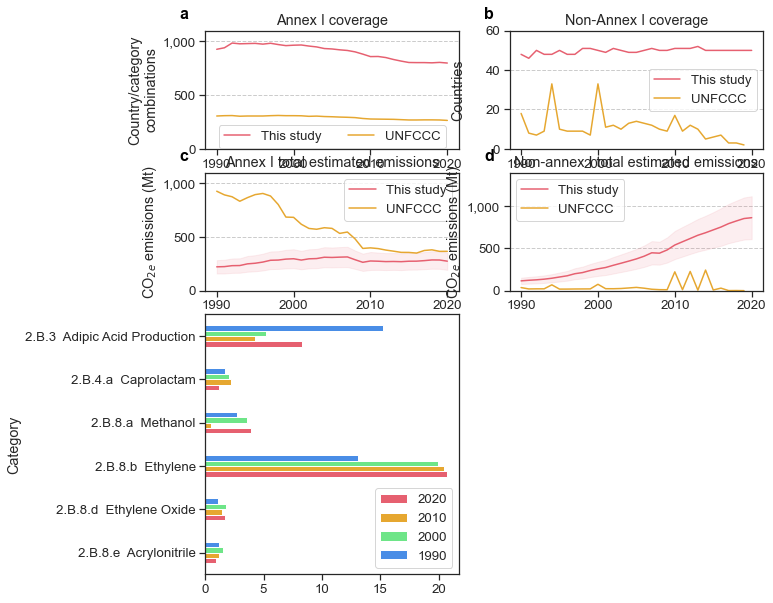

In [18]:
# Create figure
fig = plt.figure(figsize=[10,10], facecolor='white')

fontsize=12
plt.rcParams['font.size'] = 12
sns.set(font_scale=1.2)
sns.set_style('ticks')

w_loc, h_loc = -0.1, 1.2

ax = fig.add_subplot(4,2,1)

ax.set_title('Annex I coverage')
ax.plot(a1_count['Year'], a1_count['Count'], color=colors[0], label='This study')
ax.plot(u1_count['Year'], u1_count['value'], color=colors[1], label='UNFCCC')
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax.set_ylim([0,1100])
ax.grid(axis='y', linestyle='--')
ax.set_ylabel('Country/category\ncombinations')
ax.legend(loc='lower center', bbox_to_anchor=[0.5, -0.05], ncol=2)
ax.text(w_loc, h_loc, 'a', transform = ax.transAxes, fontsize=16, fontweight = 'bold', color = 'black', va='top', ha='left')

ax = fig.add_subplot(4,2,3)

ax.set_title('Annex I total estimated emissions')
scale_factor = 1E3
ax.plot(a1_tot['Year'], a1_tot['y']/scale_factor, color=colors[0], label='This study')
ax.plot(u1_tot['Year'], u1_tot['value']/scale_factor, color=colors[1], label='UNFCCC')
ax.fill_between(a1_tot['Year'], (a1_tot['y']-a1_tot['sigma_y'])/scale_factor,
                (a1_tot['y']+a1_tot['sigma_y'])/scale_factor, color=colors[0], alpha=0.1)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax.set_ylim([0,1100])
ax.grid(axis='y', linestyle='--')
ax.set_ylabel('CO$_{2e}$ emissions (Mt)')
ax.legend()
ax.text(w_loc, h_loc, 'c', transform = ax.transAxes, fontsize=16, fontweight = 'bold', color = 'black', va='top', ha='left')

ax = fig.add_subplot(4,2,2)

ax.set_title('Non-Annex I coverage')
ax.plot(a2_count['Year'], a2_count['Count'], color=colors[0], label='This study')
ax.plot(u2_count['Year'], u2_count['value'], color=colors[1], label='UNFCCC')
ax.set_ylabel('Countries\n')
ax.set_ylim([0,60])
ax.grid(axis='y', linestyle='--')
ax.legend()
ax.text(w_loc, h_loc, 'b', transform = ax.transAxes, fontsize=16, fontweight = 'bold', color = 'black', va='top', ha='left')

ax = fig.add_subplot(4,2,4)

ax.set_title('Non-annex I total estimated emissions')
scale_factor = 1E3
ax.plot(a2_tot['Year'], a2_tot['y']/scale_factor, color=colors[0], label='This study')
ax.plot(u2_tot['Year'], u2_tot['value']/scale_factor, color=colors[1], label='UNFCCC')
ax.fill_between(a2_tot['Year'], (a2_tot['y']-a2_tot['sigma_y'])/scale_factor,
                (a2_tot['y']+a2_tot['sigma_y'])/scale_factor, color=colors[0], alpha=0.1)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax.set_ylim([0,1400])
ax.grid(axis='y', linestyle='--')
ax.set_ylabel('CO$_{2e}$ emissions (Mt)')
ax.legend()
ax.text(w_loc, h_loc, 'd', transform = ax.transAxes, fontsize=16, fontweight = 'bold', color = 'black', va='top', ha='left')

## US aggregate emissions
ax = fig.add_subplot(4,2,(5,7))

country, year, gas = 'USA', [1990, 2000, 2010, 2020], 'CO2e_100a'
subset = filter_df(data_comp, ['COUNTRY/TERRITORY', 'Year','Gas'], [[country], year, [gas]])
grouped_subset = subset.groupby(['PRODUCT', 'Year']).sum().reset_index()
grouped_subset = grouped_subset.pivot(index='PRODUCT', columns='Year').reset_index()

un_filt = filter_df(unfccc_detail, ['Country', 'Equivalents'], [[country], list(equivalents.values())])
year_unfccc = year.copy()
year_unfccc[3] = 'Last Inventory Year (2020)'
un_plot = un_filt[[(str(i), 'Net emissions/removals', gas.replace(gas,gas_equivs[gas]), 'kt CO₂ equivalent') for i in year_unfccc]].reset_index().drop(columns='level_0')
un_plot.columns = ['Category']+year
un_plot['PRODUCT'] = un_plot['Category'].replace(equivalents).values

comparison = un_plot.merge(grouped_subset, how='left', on='PRODUCT')
comparison[year] = comparison[year].astype(float)
comparison = comparison[2:].sort_values(year[-1::-1]).reset_index(drop=True)

ax = plot_horiz_bars(comparison, year, ax, colors=colors)

ax.set_xscale('log')
ax.set_xlabel('CO$_{2e}$ emissions (Mt)')#, fontsize=fontsize)
ax.set_title('United States category comparison', fontsize=fontsize+2)

handles, labels = ax.get_legend_handles_labels()
handles = handles[::-1]
labels = labels[::-1]
ax.legend(handles, labels, fontsize=fontsize)

yticks = ax.get_yticks()
yticklabels = [label.get_text().replace('  ', '\n', 1).replace('Production', '') for label in ax.get_yticklabels()]
ax.set_yticks(yticks)
ax.set_yticklabels(yticklabels)
ax.set_ylabel(None)
ax.grid(axis='x')
ax.text(w_loc, h_loc-0.125, 'e', transform = ax.transAxes, fontsize=16, fontweight = 'bold', color = 'black', va='top', ha='left')

## Non annex countries
ax = fig.add_subplot(4,2,(6,8))
countries = ['Argentina', 'China', 'Colombia', 'India', 'Indonesia', 'Mexico', 'Saudi Arabia', 'South Africa']
country, year, gas, type = countries, [1990, 2000, 2010, 2012], 'CO2e_100a', ['Downstream']
subset = filter_df(data_comp, ['COUNTRY/TERRITORY', 'Year','Gas', 'Product type'], [country, year, [gas], type])
grouped_subset = subset.groupby(['COUNTRY/TERRITORY', 'Year']).sum().reset_index()
grouped_subset = grouped_subset.pivot(index='COUNTRY/TERRITORY', columns='Year').reset_index()

un_filt = filter_df(non_annex_detail, ['Country'], [countries])
year_unfccc = year.copy()
un_plot = un_filt[[(str(i), gas.replace(gas,gas_equivs[gas]), 'Gg CO₂ equivalent') for i in year_unfccc]].reset_index()
un_plot[un_plot.columns[1:]] = un_plot[un_plot.columns[1:]].replace(['NO', 'IE', 'NA', 'IE,NA','IE,NA,NE', 'NO,NA', 'NA,NO'], 0).astype(float)
grouped_un = un_plot.groupby('index').sum().reset_index()
grouped_un.columns = ['Country']+year

comparison = grouped_un.merge(grouped_subset, how='left', left_on='Country', right_on='COUNTRY/TERRITORY')

ax = plot_horiz_bars(comparison, year, ax, x_col='Country', colors=colors)

ax.set_xscale('log')
ax.set_xlabel('CO$_{2e}$ emissions (Mt)')#, fontsize=fontsize)
ax.set_title('Non-annex I country comparison', fontsize=fontsize+2)

handles, labels = ax.get_legend_handles_labels()
handles = handles[::-1]
labels = labels[::-1]
ax.legend(handles, labels, fontsize=fontsize)

yticks = ax.get_yticks()
yticklabels = [label.get_text().replace('  ', '\n', 1).replace('Production', '') for label in ax.get_yticklabels()]
ax.set_yticks(yticks)
ax.set_yticklabels(yticklabels)
ax.set_ylabel(None)
ax.grid(axis='x')
ax.text(w_loc, h_loc-0.125, 'f', transform = ax.transAxes, fontsize=16, fontweight = 'bold', color = 'black', va='top', ha='left')

fig.tight_layout()

In [31]:
# Save figure
fig.savefig('C:/Users\lukec\PycharmProjects\petrochemical-data/analysis_outputs/unfccc_stats.png', bbox_inches='tight', dpi=150)

In [17]:
def filter_df(df, cols, filters):
    for col, filt in zip(cols, filters):
        df = df[[i in filt for i in df[col]]]
    return df

## Create dataframes
def plot_bar_charts(comparison, year, ax, x_col='Category'):
    comparison.plot.bar(x=x_col, y=year, ax=ax)
    for num, yr in enumerate(year):
        ax.errorbar(comparison.index-0.2+num*0.133, comparison[('y', yr)], yerr=comparison[('sigma_y', yr)], fmt='o', color='r', ecolor='r', capsize=5, label='Calc.' if num == 0 else None)
    return ax

## Create dataframes
def plot_horiz_bars(comparison, year, ax, x_col='Category', colors=None, scale_factor = 1000):
    comparison = comparison.sort_values(x_col, ascending=False).reset_index(drop=True)
    float_cols = comparison.select_dtypes(include='float')
    comparison[float_cols.columns] = float_cols.div(scale_factor)
    comparison.plot.barh(x=x_col, y=list(year.__reversed__()), ax=ax, color=colors)
    for num, yr in enumerate(year):
        ax.errorbar(comparison[('y', yr)], comparison.index+0.2-num*0.133, xerr=comparison[('sigma_y', yr)], fmt='o', color='k', ecolor='k', capsize=3, label='Calc.' if num == 0 else None)
    return ax

## Horizontal version

In [ ]:
data_filt = data_filt[[i in ['Downstream', 'Intermediates'] for i in data_filt['Product type']]]

data_filt['Gas type'] = ['Equivalent' if i in ['CO2e_100a', 'CO2e_20a'] else 'Gas' for i in data_filt['Gas']]

data_filt_year = data_filt[data_filt['Year'] == 2020]

data_filt_gas = data_filt[data_filt['Gas'] == 'CO2e_100a']

data_filt_year_gas = data_filt_year[data_filt_year['Gas'] == 'CO2e_100a']

C:\Users\lukec\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
C:\Users\lukec\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\frame.py:9190: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left,2 on the right)
  return merge(
C:\Users\lukec\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
C:\Users\lukec\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\frame.py:9190: FutureWarning: merging between different levels is deprecated and will be removed in a fu

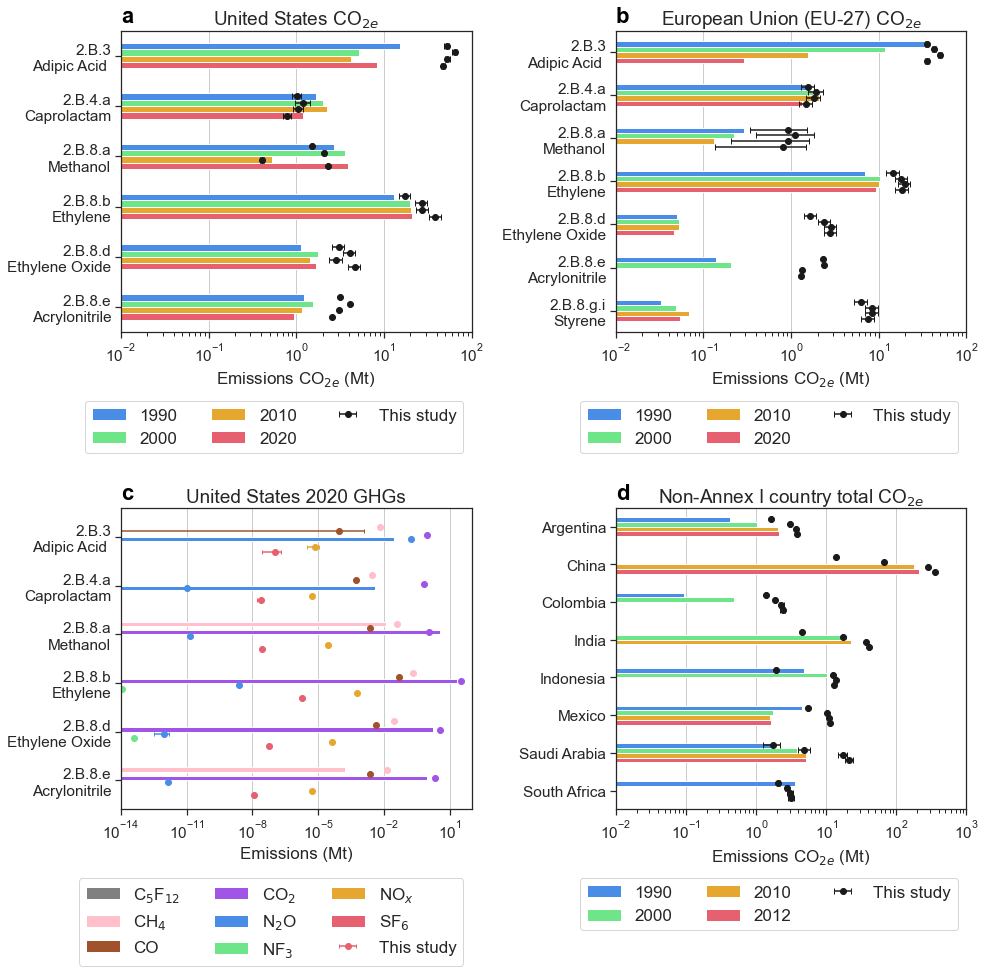

In [9]:
# Create figure
fig, axs = plt.subplots(2,2, figsize=[14,14], facecolor='white')

fontsize=17
plt.rcParams['font.size'] = 18
sns.set(font_scale=1.4)
sns.set_style('ticks')



## EU27 aggregate emissions
eu_countries = ['Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Cyprus', 'Czech Republic', 'Denmark', 'Estonia', 'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Ireland', 'Italy', 'Latvia', 'Lithuania', 'Luxembourg', 'Malta', 'Netherlands', 'Poland', 'Portugal', 'Romania', 'Slovakia', 'Slovenia', 'Spain', 'Sweden'] ##Cyprus produces no chemicals
country, year, gas = eu_countries, [1990, 2000, 2010, 2020], 'CO2e_100a'
subset = filter_df(data_filt, ['COUNTRY/TERRITORY', 'Year','Gas'], [country, year, [gas]])
grouped_subset = subset.groupby(['PRODUCT', 'Year']).sum().reset_index()
grouped_subset = grouped_subset.pivot(index='PRODUCT', columns='Year').reset_index()

un_filt = filter_df(unfccc_data, ['Country', 'Equivalents'], [country, list(equivalents.values())])
year_unfccc = year.copy()
year_unfccc[3] = 'Last Inventory Year (2020)'
un_plot = un_filt[[(str(i), 'Net emissions/removals', gas.replace(gas,gas_equivs[gas]), 'kt CO₂ equivalent') for i in year_unfccc]].reset_index().drop(columns='level_0')
un_plot[un_plot.columns[1:]] = un_plot[un_plot.columns[1:]].replace(['NO', 'IE', 'NA', 'IE,NA','IE,NA,NE', 'NO,NA', 'NA,NO'], 0).astype(float)
grouped_un = un_plot.groupby('level_1').sum().reset_index()
grouped_un.columns = ['Category']+year
grouped_un['PRODUCT'] = grouped_un['Category'].replace(equivalents).values

comparison = grouped_un.merge(grouped_subset, how='left', on='PRODUCT')
comparison[year] = comparison[year].astype(float)
comparison = comparison[2:].sort_values(year[-1::-1]).reset_index(drop=True)

axs[0,1] = plot_horiz_bars(comparison, year, axs[0,1], colors=colors)

axs[0,1].set_xscale('log')
axs[0,1].set_xlabel('Emissions CO$_{2e}$ (Mt)', fontsize=fontsize)
axs[0,1].set_title('European Union (EU-27) CO$_{2e}$', fontsize=fontsize+2)
axs[0,1].legend(fontsize=fontsize)

## US products per gas
country, gas = 'USA', list(['Carbon dioxide', 'Methane', 'Carbon monoxide', 'Dinitrogen monoxide', 'Nitric oxide', 'Nitrogen fluoride', 'Perfluoropentane', 'Sulfur hexafluoride'].__reversed__())
subset = filter_df(data_filt_year, ['COUNTRY/TERRITORY', 'Gas'], [[country], gas])
grouped_subset = subset.groupby(['PRODUCT', 'Gas']).sum().reset_index()

un_filt = filter_df(unfccc_data, ['Country', 'Equivalents'], [[country], list(equivalents.values())])
year = 2020

year_unfccc = ['Last Inventory Year (2020)']
cols = list(itertools.chain.from_iterable([[(str(i), 'Net emissions/removals', g.replace(g,gas_equivs[g]), 'kt') for i in year_unfccc] for g in gas]))
un_plot = un_filt[cols]#.drop(columns='level_0')
un_plot = un_plot.stack(level=2).reset_index()
un_plot['level_1'] = un_plot['level_1'].fillna(method='bfill')
un_plot = un_plot.dropna(subset=[un_plot.columns[2]]).drop(columns=un_plot.columns[0])
un_plot.columns = ['Category', 'Gas', year]

grouped_subset['Gas'] = grouped_subset['Gas'].replace(gas_equivs)
un_plot['PRODUCT'] = un_plot['Category'].replace(equivalents)
gs = filter_df(grouped_subset, ['PRODUCT'], [un_plot['PRODUCT'].unique()])
comparison = un_plot.merge(gs, how='right', left_on=[un_plot['Gas'].replace(gas_equivs), un_plot['Category'].replace(equivalents)],
              right_on=['Gas', 'PRODUCT'])
comparison[year] = comparison[year].replace(['NO', 'IE', 'NA', 'IE,NA','IE,NA,NE', 'NO,NA', 'NA,NO'], 0).astype(float)
comparison = comparison.dropna(subset=['y'])
comparison['Gas'] = comparison['Gas'].replace(gas_subscripts)
scale_factor = 1000
float_cols = comparison.select_dtypes(include='float')
comparison[float_cols.columns] = float_cols.div(scale_factor)
pivoted = comparison.pivot(index=['PRODUCT'], columns='Gas', values=2020).reset_index().sort_values('PRODUCT')
pivoted['Category'] = pivoted['PRODUCT'].replace({v: k for k, v in equivalents.items()})
pivoted.sort_values(['Category'], ascending=False, inplace=True)
pivoted = pivoted[pivoted.columns[-1:0:-1]]

pivoted.plot.barh(x='Category', ax=axs[1,0], width=0.7, color=colors)
comparison['Category'] = comparison['PRODUCT'].replace({v: k for k, v in equivalents.items()})
comp = comparison.sort_values(['Category'], ascending=False).reset_index(drop=True)

#colors = ['b', 'orange', 'g', 'r', 'm', 'sienna', 'pink', 'grey']
for num, (g, c) in enumerate(zip(list(pivoted.columns[1:]), colors)):
    df = comp[comp['Gas'] == g].reset_index(drop=True)
    axs[1,0].errorbar(df['y'], df.index-0.3+num*0.085, xerr=df['sigma_y'], fmt='o', color=c, ecolor=c, capsize=2, label='Calc.' if num == 0 else None)

#axs[1,0].
axs[1,0].set_xscale('log')
#axs[1,0].set_xlim([1E-4, 1e6])
axs[1,0].set_xlabel('Emissions (Mt)', fontsize=fontsize)
axs[1,0].set_title('United States 2020 GHGs', fontsize=fontsize+2)
axs[1,0].legend(fontsize=fontsize)

## Non annex countries
countries = ['Argentina', 'China', 'Colombia', 'India', 'Indonesia', 'Mexico', 'Saudi Arabia', 'South Africa']
country, year, gas, type = countries, [1990, 2000, 2010, 2012], 'CO2e_100a', ['Downstream']
subset = filter_df(data_filt, ['COUNTRY/TERRITORY', 'Year','Gas', 'Product type'], [country, year, [gas], type])
grouped_subset = subset.groupby(['COUNTRY/TERRITORY', 'Year']).sum().reset_index()
grouped_subset = grouped_subset.pivot(index='COUNTRY/TERRITORY', columns='Year').reset_index()

un_filt = filter_df(non_annex_data, ['Country'], [countries])
year_unfccc = year.copy()
un_plot = un_filt[[(str(i), gas.replace(gas,gas_equivs[gas]), 'Gg CO₂ equivalent') for i in year_unfccc]].reset_index()#.drop(columns='level_0')
un_plot[un_plot.columns[1:]] = un_plot[un_plot.columns[1:]].replace(['NO', 'IE', 'NA', 'IE,NA','IE,NA,NE', 'NO,NA', 'NA,NO'], 0).astype(float)
grouped_un = un_plot.groupby('index').sum().reset_index()
grouped_un.columns = ['Country']+year

comparison = grouped_un.merge(grouped_subset, how='left', left_on='Country', right_on='COUNTRY/TERRITORY')

axs[1,1] = plot_horiz_bars(comparison, year, axs[1,1], x_col='Country', colors=colors)

axs[1,1].set_xscale('log')
axs[1,1].set_xlabel('Emissions CO$_{2e}$ (Mt)', fontsize=fontsize)
axs[1,1].set_title('Non-Annex I country total CO$_{2e}$', fontsize=fontsize+2)
axs[1,1].legend(fontsize=fontsize)

for num, (ax, letter) in enumerate(zip([axs[0,0], axs[0,1], axs[1,0], axs[1,1]], ['a', 'b', 'c', 'd'])):

    yticks = ax.get_yticks()
    yticklabels = [label.get_text().replace('  ', '\n', 1).replace('Production', '') for label in ax.get_yticklabels()]
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticklabels)

    ax.set_ylabel(None)
    ax.grid(axis='x')
    if num!=2:
        ax.set_xlim([1E-2, 1E2])
    else: ax.set_xlim([1E-14, 1E2])
    ax.text(0, 1.08, letter, transform = ax.transAxes, fontsize=22, fontweight = 'bold', color = 'black', va='top', ha='left', **{'fontname':'Arial'})
    handles, labels = ax.get_legend_handles_labels()
    if num==3:
        ax.set_xlim([1E-2, 1E3])
    # elif num==2:
    #     loc='upper right'
    #     ax.set_xlim([1E-6, 1E2])
    #handles_ordered =
    ax.legend(handles[-2::-1]+[handles[-1]], labels[-2::-1]+['This study'], bbox_to_anchor=(1, -0.2), ncol=3, fontsize=fontsize)

fig.tight_layout()

In [10]:
# Save figure
fig.savefig('/analysis_outputs/unfccc_comparison.png', bbox_inches='tight')